# Lab 4: The Multilayer Perceptron

Ryan Schaefer

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.special import expit
import copy
import sys

# Load Data

The dataset used in this lab is United States 2017 census data by tract. The prediction task is to predict the child poverty rate of a tract when given the rest of the census data.

In [2]:
df = pd.read_csv("../Datasets/acs2017_census_tract_data.csv")

df

,TractId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001020100,Alabama,Autauga County,1845,899,946,2.4,86.3,5.2,0.0,...,0.5,0.0,2.1,24.5,881,74.2,21.2,4.5,0.0,4.6
1,1001020200,Alabama,Autauga County,2172,1167,1005,1.1,41.6,54.5,0.0,...,0.0,0.5,0.0,22.2,852,75.9,15.0,9.0,0.0,3.4
2,1001020300,Alabama,Autauga County,3385,1533,1852,8.0,61.4,26.5,0.6,...,1.0,0.8,1.5,23.1,1482,73.3,21.1,4.8,0.7,4.7
3,1001020400,Alabama,Autauga County,4267,2001,2266,9.6,80.3,7.1,0.5,...,1.5,2.9,2.1,25.9,1849,75.8,19.7,4.5,0.0,6.1
4,1001020500,Alabama,Autauga County,9965,5054,4911,0.9,77.5,16.4,0.0,...,0.8,0.3,0.7,21.0,4787,71.4,24.1,4.5,0.0,2.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73996,72153750501,Puerto Rico,Yauco Municipio,6011,3035,2976,99.7,0.3,0.0,0.0,...,0.5,0.0,3.6,26.9,1576,59.2,33.8,7.0,0.0,20.8
73997,72153750502,Puerto Rico,Yauco Municipio,2342,959,1383,99.1,0.9,0.0,0.0,...,0.0,0.0,1.3,25.3,666,58.4,35.4,6.2,0.0,26.3
73998,72153750503,Puerto Rico,Yauco Municipio,2218,1001,1217,99.5,0.2,0.0,0.0,...,3.4,0.0,3.4,23.5,560,57.5,34.5,8.0,0.0,23.0
73999,72153750601,Puerto Rico,Yauco Municipio,4380,1964,2416,100.0,0.0,0.0,0.0,...,0.0,0.0,0.0,24.1,1062,67.7,30.4,1.9,0.0,29.5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74001 entries, 0 to 74000
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TractId           74001 non-null  int64  
 1   State             74001 non-null  object 
 2   County            74001 non-null  object 
 3   TotalPop          74001 non-null  int64  
 4   Men               74001 non-null  int64  
 5   Women             74001 non-null  int64  
 6   Hispanic          73305 non-null  float64
 7   White             73305 non-null  float64
 8   Black             73305 non-null  float64
 9   Native            73305 non-null  float64
 10  Asian             73305 non-null  float64
 11  Pacific           73305 non-null  float64
 12  VotingAgeCitizen  74001 non-null  int64  
 13  Income            72885 non-null  float64
 14  IncomeErr         72885 non-null  float64
 15  IncomePerCap      73256 non-null  float64
 16  IncomePerCapErr   73256 non-null  float6

In [4]:
df.shape

(74001, 37)

In [5]:
df_processed = copy.deepcopy(df)

For our purposes, we do not need the TractId and County features. The TractId is a unique identifier for each instance, which means it is not a useful feature to fit a model with. The county feature can be removed, because some counties only have 1 tract. This means that some counties may only be in the testing data. 

In [6]:
df_processed = df_processed.drop(["TractId", "County"], axis = 1).dropna()
df_processed.shape

(72718, 35)

In [7]:
df_processed["State"] = df_processed["State"].astype('category').cat.codes

df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72718 entries, 0 to 74000
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   State             72718 non-null  int8   
 1   TotalPop          72718 non-null  int64  
 2   Men               72718 non-null  int64  
 3   Women             72718 non-null  int64  
 4   Hispanic          72718 non-null  float64
 5   White             72718 non-null  float64
 6   Black             72718 non-null  float64
 7   Native            72718 non-null  float64
 8   Asian             72718 non-null  float64
 9   Pacific           72718 non-null  float64
 10  VotingAgeCitizen  72718 non-null  int64  
 11  Income            72718 non-null  float64
 12  IncomeErr         72718 non-null  float64
 13  IncomePerCap      72718 non-null  float64
 14  IncomePerCapErr   72718 non-null  float64
 15  Poverty           72718 non-null  float64
 16  ChildPoverty      72718 non-null  float6

## Training/Testing Split

For this analysis, we will split the data into training and testing sets. We will use a random 80% of the data for training and the remaining 20% for testing.

In [8]:
df_temp = copy.deepcopy(df_processed)
y = df_temp.pop("ChildPoverty").to_numpy()
X = df_temp.to_numpy()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X ,y, test_size = 0.2, random_state = 7324)

## Data Balancing

Before we can begin training our models, we need to convert the numeric ChildPoverty column into a categorical variable with 4 classes. We want the training data to have an even distribution of the 4 classes, so we can split the data by the quartiles. The distribution of the classes in the testing data should reflect the actual data, so the training quartiles will be used to split both the training and testing sets.

In [10]:
poverty_train = pd.DataFrame({
    "ChildPoverty": y_train
})

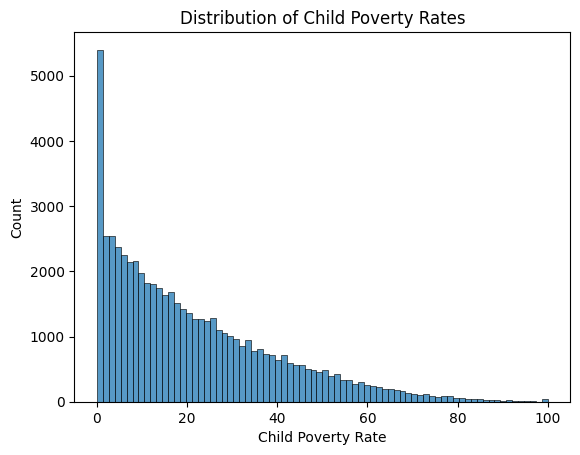

In [11]:
sns.histplot(data = poverty_train, x = "ChildPoverty")

plt.title("Distribution of Child Poverty Rates")
plt.xlabel("Child Poverty Rate")

plt.show()

In [12]:
poverty_stats = poverty_train["ChildPoverty"].describe()

poverty_stats

count    58174.000000
mean        21.205329
std         18.627824
min          0.000000
25%          6.200000
50%         16.400000
75%         31.700000
max        100.000000
Name: ChildPoverty, dtype: float64

The description of the ChildPoverty column gives us the quartiles of the data. Based on the description, class 0 is less than 6.2, class 1 is less than 16.4, class 2 is less than 31.7, and everything else is class 3.

In [13]:
bins = [
    poverty_stats["min"] - 1,
    poverty_stats["25%"],
    poverty_stats["50%"],
    poverty_stats["75%"],
    poverty_stats["max"] + 1
]

poverty_train["ChildPovertyClass"] = pd.cut(
    poverty_train["ChildPoverty"],
    bins,
    labels = False
)

poverty_train["ChildPovertyClass"].value_counts()

1    14609
0    14590
3    14507
2    14468
Name: ChildPovertyClass, dtype: int64

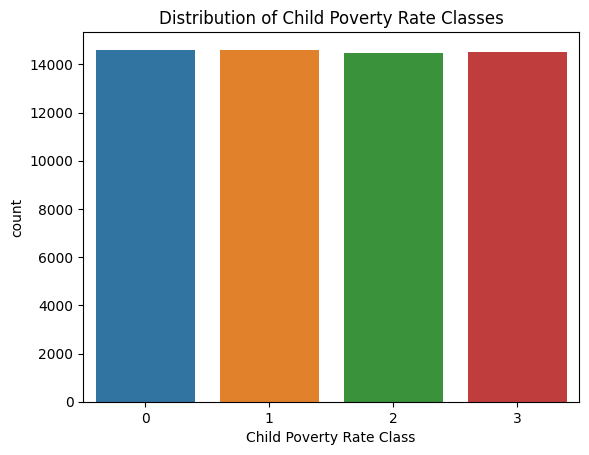

In [14]:
poverty_train["ChildPovertyClass"] = poverty_train["ChildPovertyClass"].astype(str)

sns.countplot(data = poverty_train.sort_values("ChildPovertyClass"), x = "ChildPovertyClass")

plt.title("Distribution of Child Poverty Rate Classes")
plt.xlabel("Child Poverty Rate Class")

plt.show()

The bar chart above shows that the distribution of classes in the training set is not exactly the same, but is approximately equal. We can now apply these bounds to split the testing data into classes.

In [15]:
poverty_test = pd.DataFrame({
    "ChildPoverty": y_test
})

poverty_test["ChildPovertyClass"] = pd.cut(
    poverty_test["ChildPoverty"],
    bins,
    labels = False
)

poverty_test["ChildPovertyClass"].value_counts()

1    3724
0    3639
2    3607
3    3574
Name: ChildPovertyClass, dtype: int64

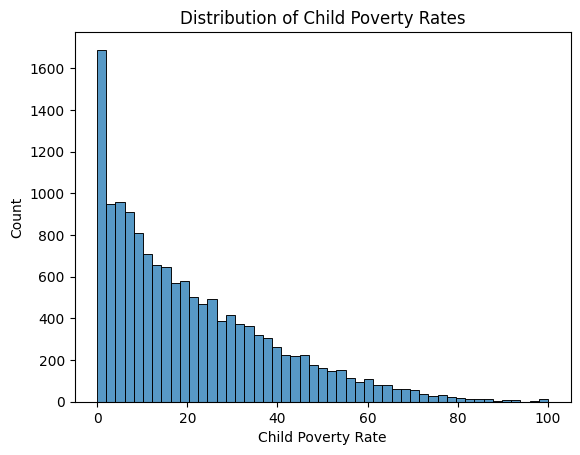

In [16]:
sns.histplot(data = poverty_test, x = "ChildPoverty")

plt.title("Distribution of Child Poverty Rates")
plt.xlabel("Child Poverty Rate")

plt.show()

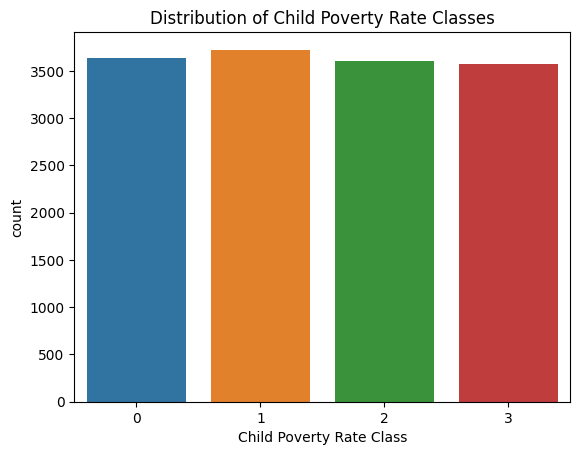

In [17]:
poverty_test["ChildPovertyClass"] = poverty_test["ChildPovertyClass"].astype(str)

sns.countplot(data = poverty_test.sort_values("ChildPovertyClass"), x = "ChildPovertyClass")

plt.title("Distribution of Child Poverty Rate Classes")
plt.xlabel("Child Poverty Rate Class")

plt.show()

The bar chat above shows that the distribution of child poverty classes is not as equal as the training data, but none of the classes have significantly more or less instances than the others.

In [18]:
y_train = poverty_train["ChildPovertyClass"].astype(int).to_numpy()
y_test = poverty_test["ChildPovertyClass"].astype(int).to_numpy()

# Initial Modeling

For our initial modeling, we can use a 2-layer perceptron. This implementation is based on the code from [Dr Larson's GitHub repository](https://github.com/eclarson/MachineLearningNotebooks/blob/master/08a.%20Practical_NeuralNets%20with%20Bias.ipynb). This implementation includes vectorized gradient computation, mini-batching, cross entropy loss, and Glorot initialization.
- Vectorized gradient computation optimizes gradient calculations using vectors instead of for loops.
- Mini-batching trains the model using subsets of the data instead of the entire dataset, increasing the speed of the fitting process.
- Cross entropy loss is a better loss function than mean square error (MSE) for classification problems, because the loss curve will flatten in fewer epochs. 
- Glorot initialization initializes the model weights such that it will not saturate the neurons right away. This implementation initializes the weights using a uniform distribution, but a normal distribution could have also been used.

In [19]:
class TwoLayerPerceptron(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None,
                 alpha=0.0, decrease_const=0.0, decrease_iter = 10, 
                 shuffle=True, minibatches=1):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.decrease_iter = decrease_iter
        self.shuffle = shuffle
        self.minibatches = minibatches
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_))

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden)) 
        
        # set these to zero to start so that
        # they do not immediately saturate the neurons
        b1 = np.zeros((self.n_hidden, 1))
        b2 = np.zeros((self.n_output_, 1))
        
        return W1, W2, b1, b2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3+1e-7)+(1-Y_enc)*np.log(1-A3+1e-7))))
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2, b1, b2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = (A3-Y_enc) # <- this is only line that changed
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C

        return gradW1, gradW2, gradb1, gradb2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2, self.b1, self.b2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.b1, self.b2 = self._initialize_weights()

        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape) # for momentum
        rho_W2_prev = np.zeros(self.W2.shape) # for momentum

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            self.val_cost_ = []
            
        for i in range(self.epochs):

            # adaptive learning rate
            # decrease at certain epochs
            eta = self.eta * self.decrease_const**(np.floor(i/self.decrease_iter))

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.b1,
                                                       self.b2
                                                      )
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradW1, gradW2, gradb1, gradb2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)

                
                
                # simple momentum calculations
                rho_W1, rho_W2 = eta * gradW1, eta * gradW2
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev)) # update with momentum
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev)) # update with momentum
                
                # no need for momentum in bias 
                # these values need to change abruptly and 
                # do not influence sensitivity backward
                self.b1 -= eta * gradb1
                self.b2 -= eta * gradb2
                
                # update previous parameters 
                rho_W1_prev, rho_W2_prev = rho_W1, rho_W2
                
                

            self.cost_.append(np.mean(mini_cost))
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            
            # update if a validation set was provided
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test,yhat))
            
        return self

In [20]:
hyperparameters = {
    "n_hidden": 50, 
    "C": 1e-2, 
    "epochs": 100, 
    "eta": 0.001, 
    "alpha": 0.1, 
    "decrease_const": 0.1,
    "minibatches": int(len(X_train)/256),
    "shuffle": True,
    "random_state": 7324
}

model_2layer_1 = TwoLayerPerceptron(**hyperparameters)

## No Preprocessing Model

In [21]:
%%time

model_2layer_1.fit(X_train, y_train, print_progress = 1)

yhat_2layer_1 = model_2layer_1.predict(X_test)
print('Accuracy:', accuracy_score(y_test, yhat_2layer_1))

Epoch: 100/100

Accuracy: 0.25886963696369636
CPU times: user 5min 45s, sys: 41.2 s, total: 6min 27s
Wall time: 35.7 s


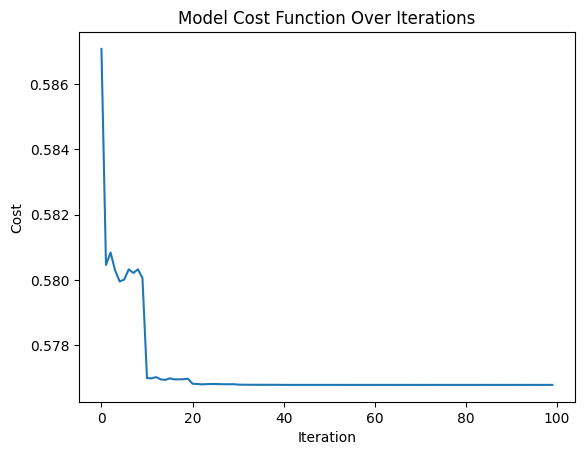

In [22]:
plt.plot(list(map(np.mean, model_2layer_1.cost_)))

plt.title("Model Cost Function Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Cost")

plt.show()

The first model is fit without any preprocessing done on the data. This model only yields an accuracy of 25.9%, making it barely better than random chance. The line plot above shows that the training did converge, as the loss function flattened out.

## Normalized Model

In [23]:
normalizer = StandardScaler()
X_norm = normalizer.fit_transform(df_temp)
X_train_norm, X_test_norm = train_test_split(X_norm, test_size = 0.2, random_state = 7324)
model_2layer_2 = TwoLayerPerceptron(**hyperparameters)

In [24]:
%%time

model_2layer_2.fit(X_train_norm, y_train, print_progress = 1)

yhat_2layer_2 = model_2layer_2.predict(X_test_norm)
print('Accuracy:', accuracy_score(y_test, yhat_2layer_2))

Epoch: 100/100

Accuracy: 0.7202970297029703
CPU times: user 7min 33s, sys: 1min 2s, total: 8min 36s
Wall time: 48.9 s


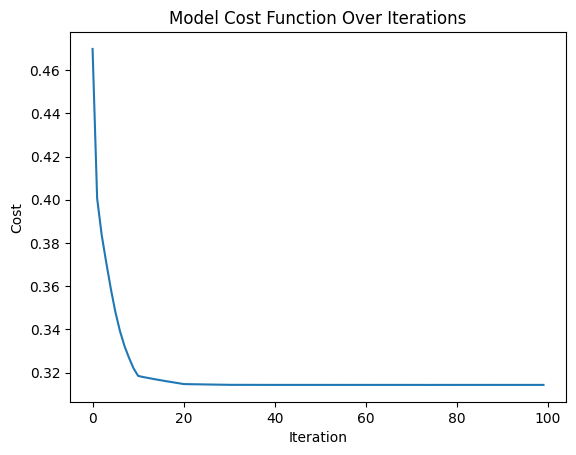

In [25]:
plt.plot(list(map(np.mean, model_2layer_2.cost_)))

plt.title("Model Cost Function Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Cost")

plt.show()

The second model was fit after normalizing all of the features. This model produced a much better accuracy of 72%.  The line plot above shows that the training did converge, as the loss function flattened out.

## One-Hot Encoded Model

In [26]:
df_onehot = copy.deepcopy(df_temp)

# county_dummies = pd.get_dummies(df_onehot["County"]).add_prefix("county_")
state_dummies = pd.get_dummies(df_onehot["State"]).add_prefix("state_")

df_onehot = df_onehot.join(state_dummies)
df_onehot = df_onehot.drop("State", axis = 1)
X_norm_onehot = normalizer.fit_transform(df_onehot)

X_train_norm_onehot, X_test_norm_onehot = train_test_split(X_norm_onehot, test_size = 0.2, random_state = 7324)
model_2layer_3 = TwoLayerPerceptron(**hyperparameters)

In [27]:
%%time

model_2layer_3.fit(X_train_norm_onehot, y_train, print_progress = 1)

yhat_2layer_3 = model_2layer_3.predict(X_test_norm_onehot)
print('Accuracy:', accuracy_score(y_test, yhat_2layer_3))

Epoch: 100/100

Accuracy: 0.6920379537953796
CPU times: user 7min 39s, sys: 1min 6s, total: 8min 46s
Wall time: 49 s


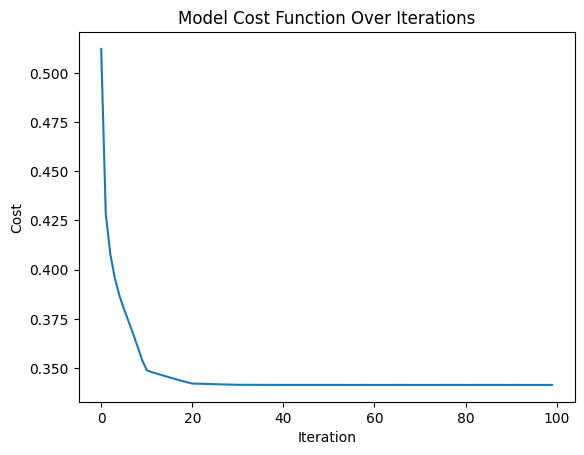

In [28]:
plt.plot(list(map(np.mean, model_2layer_3.cost_)))

plt.title("Model Cost Function Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Cost")

plt.show()

The third and final 2-layer model was fit after normalizing all of the features and one hot encoding the categorical features (just the state in this dataset). This model produced a slightly lower accuracy of 69.2%. The line plot above shows that the training did converge, as the loss function flattened out.

## Model Comparison

However, the accuracy on its own is not enough to determine which model performed the best. To do this, we can use the McNemar test. The McNemar test only assumes that the models were tested on the same testing instances, and tests the null hypothesis that the predictive capability of 2 models is not different on this data. If we reject the null hypothesis, we can conclude that the models perform differently on the testing data. If the null hypothesis is rejected, we can assume that the model with the better accuracy performs significantly better than the other on this testing set. As we have more than 2 models, we will compare each pair of models using the McNemar test and determine if any of the models is clearly the best based on the results.

Souce: McNemar and Edwards, 1948

The function below will conduct the McNemar test for 2 sets of predictions on a given set of testing labels. The function will compute the test statistic for the test, and return true if the null hypothesis should be rejected at the 95% confidence level.

In [29]:
# Function to conduct the McNemar test for 2 sets of predictions
# Returns true if we reject the null hypothesis (the models are different)
def mcnemar_test(y, yhat1, yhat2):
    # Calculate B and C
    B = 0
    C = 0
    for i in range(len(y)):
        # If yhat1 and yhat2 match, then neither B nor C
        if yhat1[i] == yhat2[i]:
            continue
        else:
            # If yhat1 and y match, then B
            if y[i] == yhat1[i]:
                B += 1
            # Else, C
            else:
                C += 1
    
    # Calculate test statistic
    x2 = ((abs(B - C) - 1) ** 2) / (B + C)
    
    # Determine if we should reject the null hypothesis or not
    return x2 > 3.841

In [30]:
models_compare = pd.DataFrame({
    "Model 1": [ "No Preprocessing", "No Preprocessing", "Normalized"],
    "Model 2": [ "Normalized", "One-Hot Encoded", "One-Hot Encoded"],
    "Models Are Different": [
        mcnemar_test(y_test, yhat_2layer_1, yhat_2layer_2),
        mcnemar_test(y_test, yhat_2layer_1, yhat_2layer_3),
        mcnemar_test(y_test, yhat_2layer_2, yhat_2layer_3)
    ]
})

display(models_compare)

,Model 1,Model 2,Models Are Different
0,No Preprocessing,Normalized,True
1,No Preprocessing,One-Hot Encoded,True
2,Normalized,One-Hot Encoded,True


The table above shows if the models produced significantly different results on the testing data (rejected the null hypothesis for the McNemar test). According to the table, all of the models are different, meaning that the highest accuracy can be concluded to be the best of these models. The normalized model (without one-hot encoding) produced the best accuracy, so we can conclude that it was the best model for this testing set.

# Multi-Layer Modeling

To further increase the accuracy of our predictions, add more layers to the perceptron. The code below is a modified version of the prior 2-layer perceptron that is capable of fitting a model with any specified number of layers. Rather than hard coding the variables that exist in each layer, like the weights and gradients, this implementation uses a list for each of those variables and appends a value to that list for each layer. This implementation also keeps track of the magnitude of the gradient for each layer at each iteration and provides functionality to get the gradient magnitudes or plot them after fitting a model. All models fit using the multi-layer implementation will use the one-hot encoded training data.

In [31]:
class MultiLayerPerceptron(object):
    def __init__(self, layers = 2, n_hidden=[30],
                 C=0.0, epochs=500, eta=0.001, random_state=None,
                 alpha=0.0, decrease_const=0.1, 
                 decrease_iter = 10, shuffle=True, 
                 minibatches=1):
        np.random.seed(random_state)
        self.n_hidden = copy.deepcopy(n_hidden)
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.layers = layers
        
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.decrease_iter = decrease_iter
        self.shuffle = shuffle
        self.minibatches = minibatches
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        W = []
        b = []
        for i in range(self.layers):
            init_bound = 4 * np.sqrt(6. / (self.n_hidden[i + 1] + self.n_hidden[i]))
            curr_W = np.random.uniform(-init_bound, init_bound, (self.n_hidden[i + 1], self.n_hidden[i]))
            curr_W[:, :1] = 0
            W.append(curr_W)
            b.append(np.zeros((self.n_hidden[i + 1], 1)))

        return W, b
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _L2_reg(lambda_, W):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        terms = 0
        for term in W:
            terms += np.mean(term[:, 1:] ** 2)
        return (lambda_) * np.sqrt(terms)
    
    def _cost(self,A,Y_enc,W):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A)+(1-Y_enc)*np.log(1-A))))
        L2_term = self._L2_reg(self.l2_C, W)
        return cost + L2_term
    
    def _feedforward(self, X, W, b):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A = []
        Z = []
        for i in range(self.layers):
            if i == 0:
                A.append(X.T)
            else:
                A.append(self._sigmoid(Z[i - 1]))
            Z.append(W[i] @ A[i] + b[i])
        A.append(self._sigmoid(Z[self.layers - 1]))

        return A, Z
    
    def _get_gradient(self, A, Z, Y_enc, W):
        """ Compute gradient step using backpropagation.
        """
        V = []
        grad = []
        gradb = []
        
        V.append(A[self.layers] - Y_enc)
        for i in range(self.layers - 1, 0, -1):
            V.insert(0, A[i] * (1 - A[i]) * (W[i].T @ V[0]))

        for i in range(self.layers):
            curr_grad = V[i] @ A[i].T
            curr_grad += W[i] * self.l2_C
            grad.append(curr_grad)
            gradb.append(np.sum(V[i], axis = 1).reshape((-1, 1)))

        return grad, gradb
    
    def predict(self, X):
        """Predict class labels"""
        A, Z = self._feedforward(X, self.W, self.b)
        y_pred = np.argmax(A[self.layers], axis=0)
        return y_pred
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.n_hidden.insert(0, self.n_features_)
        self.n_hidden.append(self.n_output_)
        self.W, self.b = self._initialize_weights()

        # Array to store gradient magnitudes
        self.grads_ = []
        # Array to store prev rho values
        rho_W_prev = []
        for i in range(self.layers):
            self.grads_.append(np.zeros(self.epochs))
            rho_W_prev.append(np.zeros(self.W[i].shape))

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        for i in range(self.epochs):

            # adaptive learning rate
            # \frac{\eta}{1+\epsilon\cdot k}
            eta = self.eta / (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A, Z = self._feedforward(X_data[idx], self.W, self.b)
                
                cost = self._cost(A[self.layers], Y_enc[:, idx], self.W)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad, gradb = self._get_gradient(A, Z, Y_enc[:, idx], self.W)

                # momentum calculations
                for j in range(self.layers):
                    rho = eta * grad[j]
                    self.W[j] -= rho + (self.alpha * rho_W_prev[j])
                    rho_W_prev[j] = rho
                    
                    # no need for momentum in bias 
                    # these values need to change abruptly and 
                    # do not influence sensitivity backward
                    self.b[j] -= eta * gradb[j]
                    
                    # Store gradient magnitudes
                    self.grads_[j][i] = np.mean(np.abs(grad[j]))

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        return self
    
    # Get the gradient magnitudes for the specified layer or all layers is param set to None
    def get_gradients_(self, layer = None):
        if layer == None:
            return self.grads_
        else:
            return self.grads_[layer - 1]
        
    # Generate a visualization of the gradient magnitudes for each layer over the epochs
    def plot_gradients_(self):
        ax = plt.subplot(1,1,1)
        for i in range(self.layers):
            plt.plot(self.grads_[i], label='w{}'.format(i + 1))
        plt.legend()
        plt.ylabel('Average gradient magnitude')
        plt.xlabel('Iteration')
        plt.show()

## 3 Layers

In [32]:
hyperparameters["n_hidden"] = [50, 40]
hyperparameters["layers"] = 3

model_3layer = MultiLayerPerceptron(**hyperparameters)

In [33]:
%%time

model_3layer.fit(X_train_norm_onehot, y_train, print_progress = 1)

yhat_3layer = model_3layer.predict(X_test_norm_onehot)
print('Accuracy:', accuracy_score(y_test, yhat_3layer))

Epoch: 100/100

Accuracy: 0.7328107810781078
CPU times: user 20min 31s, sys: 2min, total: 22min 32s
Wall time: 2min 16s


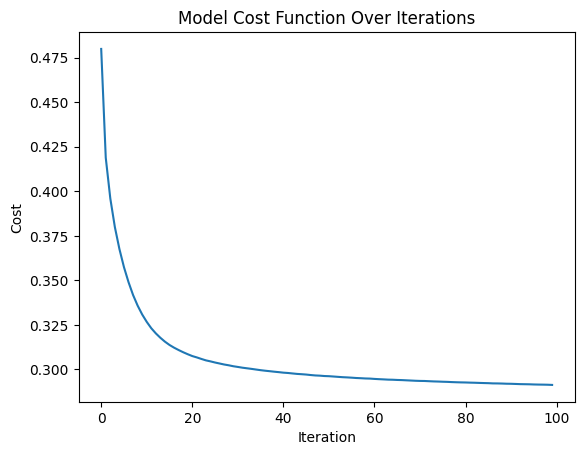

In [34]:
plt.plot(list(map(np.mean, model_3layer.cost_)))

plt.title("Model Cost Function Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Cost")

plt.show()

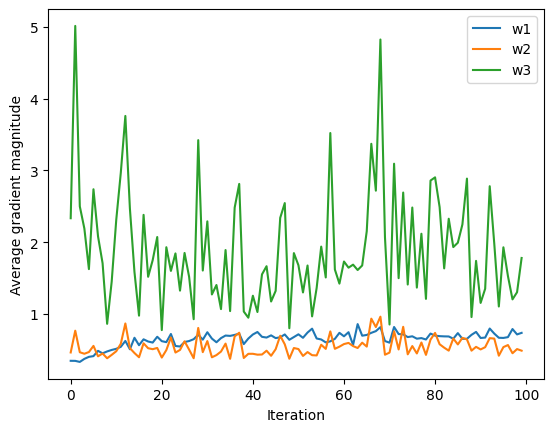

In [35]:
model_3layer.plot_gradients_()

The 3-layer perceptron produced a higher accuracy than the 2-layer perceptron (73.3% vs 69.2%). The first line plot shows that the training converged, as the loss function flattens out. The second line plot shows that the gradient of the 3rd layer consistently has a larger magnitude than the other 2 layers.

## 4 Layers

In [36]:
hyperparameters["n_hidden"] = [50, 40, 30]
hyperparameters["layers"] = 4

model_4layer = MultiLayerPerceptron(**hyperparameters)

In [37]:
%%time

model_4layer.fit(X_train_norm_onehot, y_train, print_progress = 1)

yhat_4layer = model_4layer.predict(X_test_norm_onehot)
print('Accuracy:', accuracy_score(y_test, yhat_4layer))

Epoch: 100/100

Accuracy: 0.7326732673267327
CPU times: user 21min 38s, sys: 2min 11s, total: 23min 49s
Wall time: 2min 16s


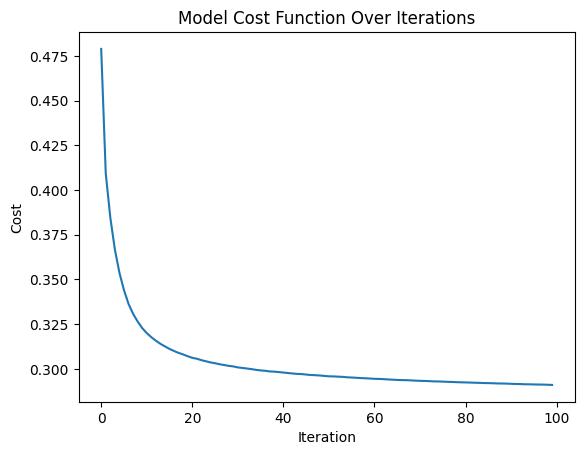

In [38]:
plt.plot(list(map(np.mean, model_4layer.cost_)))

plt.title("Model Cost Function Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Cost")

plt.show()

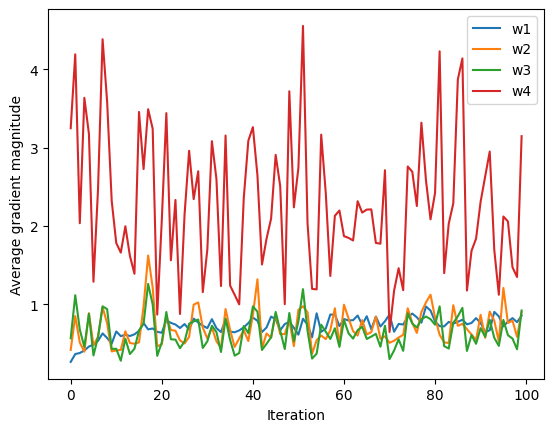

In [39]:
model_4layer.plot_gradients_()

The 4-layer perceptron produced approximately the same accuracy as the 3-layer perceptron (73.27% vs 73.28%). The first line plot shows that the training converged, as the loss function flattens out. The second line plot shows that the gradient of the 4th layer consistently has a larger magnitude than the other 3 layers.

## 5 Layers

In [40]:
hyperparameters["n_hidden"] = [50, 40, 30, 20]
hyperparameters["layers"] = 5

model_5layer = MultiLayerPerceptron(**hyperparameters)

In [41]:
%%time

model_5layer.fit(X_train_norm_onehot, y_train, print_progress = 1)

yhat_5layer = model_5layer.predict(X_test_norm_onehot)
print('Accuracy:', accuracy_score(y_test, yhat_5layer))

Epoch: 100/100

Accuracy: 0.7306793179317932
CPU times: user 21min 2s, sys: 2min 16s, total: 23min 19s
Wall time: 2min 9s


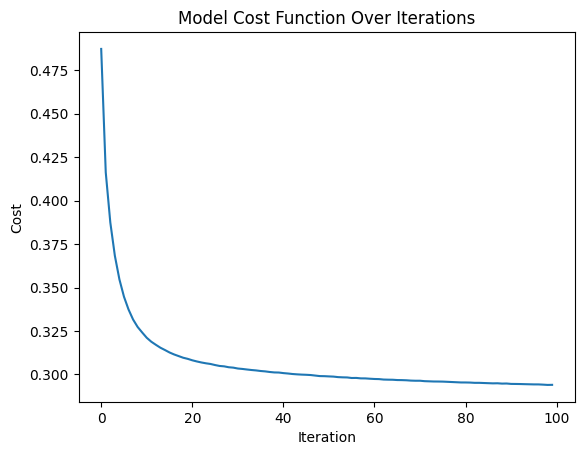

In [42]:
plt.plot(list(map(np.mean, model_5layer.cost_)))

plt.title("Model Cost Function Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Cost")

plt.show()

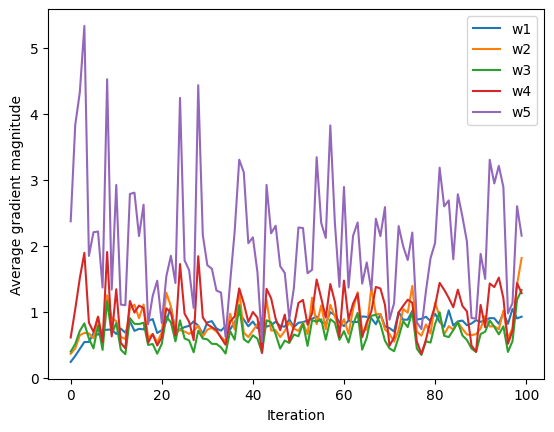

In [43]:
model_5layer.plot_gradients_()

The 5-layer perceptron produced a slightly lower accuracy as the 4-layer perceptron (73.1% vs 73.3%). The first line plot shows that the training converged, as the loss function flattens out. The second line plot shows that the gradient of the 5th layer consistently has a larger magnitude than the other 4 layers.

## Adaptive Learning (RMSProp)

The optimize the fitting process, we want the gradient updates to "speed up" when the objective function plateaus (the gradient is close to 0) and "slow down" when the objective function's slope is steep (the gradient is large). To do this, we can use an adaptive learning technique. All adaptive learning techniques are based on the idea of using a transformation of the inverse magnitude of the gradient as a multiplier for the gradient to determine when to "speed up" and when to "slow down". A common adaptive learning technique is RMSProp, which is implemented in the code below. RMSProp computes the gradient magnitude as a matrix called V. V is calculated using the following equation:

$V_k = \alpha \cdot V_{k-1} + (1 - \alpha) \cdot G_k$, where $G_k = \nabla J(W_k) \odot \nabla J(W_k)$

This new implementation inherits the previous multi-layer implementation and adds RMSProp to the gradient updates.

In [44]:
class MLPAdaptiveRMSProp(MultiLayerPerceptron):
    def __init__(self, epsilon = 1e-7, **kwds):
        self.epsilon = epsilon
        super().__init__(**kwds)
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.n_hidden.insert(0, self.n_features_)
        self.n_hidden.append(self.n_output_)
        self.W, self.b = self._initialize_weights()
        
        # Array to store gradient magnitudes
        self.grads_ = []
        # Array to store prev rho values
        rho_W_prev = []
        # Array to store prev V values
        V_prev = []
        for i in range(self.layers):
            self.grads_.append(np.zeros(self.epochs))
            rho_W_prev.append(np.zeros(self.W[i].shape))
            V_prev.append(np.zeros(self.W[i].shape))
            
        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        for i in range(self.epochs):

            # adaptive learning rate
            # \frac{\eta}{1+\epsilon\cdot k}
            eta = self.eta / (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A, Z = self._feedforward(X_data[idx], self.W, self.b)
                
                cost = self._cost(A[self.layers], Y_enc[:, idx], self.W)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad, gradb = self._get_gradient(A, Z, Y_enc[:, idx], self.W)

                # momentum calculations
                for j in range(self.layers):
                    # RMSProp calculations
                    G = grad[j] * grad[j]
                    V = self.alpha * V_prev[j] + (1 - self.alpha) * G
                    rho = eta * grad[j] / np.sqrt(V + self.epsilon)
  
                    self.W[j] -= rho + (self.alpha * rho_W_prev[j])
                    rho_W_prev[j] = rho
                    
                    # no need for momentum in bias 
                    # these values need to change abruptly and 
                    # do not influence sensitivity backward
                    self.b[j] -= eta * gradb[j]
                    
                    # Store gradient magnitudes
                    self.grads_[j][i] = np.mean(np.abs(grad[j]))

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        return self

In [45]:
model_5layer_rmsprop = MLPAdaptiveRMSProp(**hyperparameters)

In [46]:
%%time

model_5layer_rmsprop.fit(X_train_norm_onehot, y_train, print_progress = 1)

yhat_5layer_rmsprop = model_5layer_rmsprop.predict(X_test_norm_onehot)
print('Accuracy:', accuracy_score(y_test, yhat_5layer_rmsprop))

Epoch: 100/100

Accuracy: 0.7290291529152916
CPU times: user 21min 46s, sys: 2min 17s, total: 24min 3s
Wall time: 2min 13s


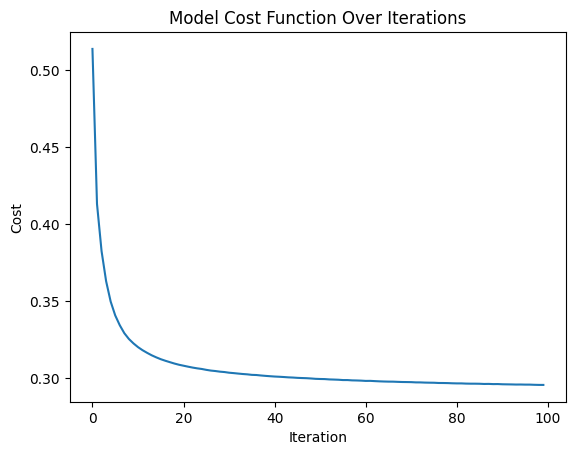

In [47]:
plt.plot(list(map(np.mean, model_5layer_rmsprop.cost_)))

plt.title("Model Cost Function Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Cost")

plt.show()

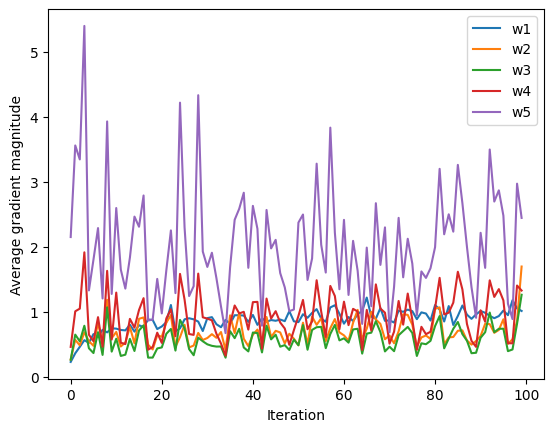

In [48]:
model_5layer_rmsprop.plot_gradients_()

In [49]:
mcnemar_test(y_test, yhat_5layer, yhat_5layer_rmsprop)

False

A model using RMSProp on a 5-layer perceptron produces approximately the same accuracy as a 5-layer perceptron without RMSProp on this testing set (72.9% vs 73.1%). We fail to reject the null hypothesis for the McNemar test, so we cannot conclude that the predictions of the models are different. 

# Adaptive Momentum (AdaM)

Another adaptive learning technique is Adaptive Momentum (AdaM). AdaM not only computes a transformation of the inverse gradient magnitude, but also transforms the gradient itself. The matrix V is still used for the gradient magnitude, but it is now calculated with the following equation:

$V_k = \beta_2 \cdot V_{k-1} + (1 - \beta_2) \cdot \nabla J(W_k) \odot \nabla J(W_k)$

We now add a new matrix M, which is the transformed gradient. M is calculated with the following equation:

$M_k = \beta_1 \cdot M_{k-1} + (1 - \beta_1) \cdot \nabla J(W_k)$

Before being used in the weight update, both V and M are divided by $(1 - \beta^k)$, where V uses $\beta_2$ and M uses $\beta_1$. This is done so that the denominator is small at low epochs and gets larger over time. This makes both the transformed gradient and the inverse gradient magnitude much larger at the start and decrease in magnitude over time.

In [50]:
class MLPAdaptiveAdaM(MLPAdaptiveRMSProp):
    def __init__(self, beta1 = 0.9, beta2 = 0.999, **kwds):
        self.beta1 = beta1
        self.beta2 = beta2
        super().__init__(**kwds)
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.n_hidden.insert(0, self.n_features_)
        self.n_hidden.append(self.n_output_)
        self.W, self.b = self._initialize_weights()
        
        # Array to store gradient magnitudes
        self.grads_ = []
        # Array to store prev rho values
        rho_W_prev = []
        # Array to store prev V values
        V_prev = []
        # Array to store prev M values
        M_prev = []
        for i in range(self.layers):
            self.grads_.append(np.zeros(self.epochs))
            rho_W_prev.append(np.zeros(self.W[i].shape))
            V_prev.append(np.zeros(self.W[i].shape))
            M_prev.append(np.zeros(self.W[i].shape))
            
        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        for i in range(self.epochs):

            # adaptive learning rate
            # \frac{\eta}{1+\epsilon\cdot k}
            eta = self.eta / (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A, Z = self._feedforward(X_data[idx], self.W, self.b)
                
                cost = self._cost(A[self.layers], Y_enc[:, idx], self.W)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad, gradb = self._get_gradient(A, Z, Y_enc[:, idx], self.W)

                # momentum calculations
                for j in range(self.layers):
                    # AdaM calculations
                    k = i + 1
                    M = self.beta1 * M_prev[j] + (1 - self.beta1) * grad[j]
                    V = self.beta2 * V_prev[j] + (1 - self.beta2) * grad[j] * grad[j]
                    M_hat = M / (1 - self.beta1 ** k)
                    V_hat = V / (1 - self.beta2 ** k)
                    rho = eta * M_hat / (np.sqrt(V_hat + self.epsilon))
  
                    self.W[j] -= rho + (self.alpha * rho_W_prev[j])
                    rho_W_prev[j] = rho
                    
                    # no need for momentum in bias 
                    # these values need to change abruptly and 
                    # do not influence sensitivity backward
                    self.b[j] -= eta * gradb[j]
                    
                    # Store gradient magnitudes
                    self.grads_[j][i] = np.mean(np.abs(grad[j]))

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        return self

In [51]:
model_5layer_adam = MLPAdaptiveAdaM(**hyperparameters)

In [52]:
%%time

model_5layer_adam.fit(X_train_norm_onehot, y_train, print_progress = 1)

yhat_5layer_adam = model_5layer_adam.predict(X_test_norm_onehot)
print('Accuracy:', accuracy_score(y_test, yhat_5layer_adam))

Epoch: 100/100

Accuracy: 0.7269664466446645
CPU times: user 22min 23s, sys: 2min 22s, total: 24min 45s
Wall time: 2min 17s


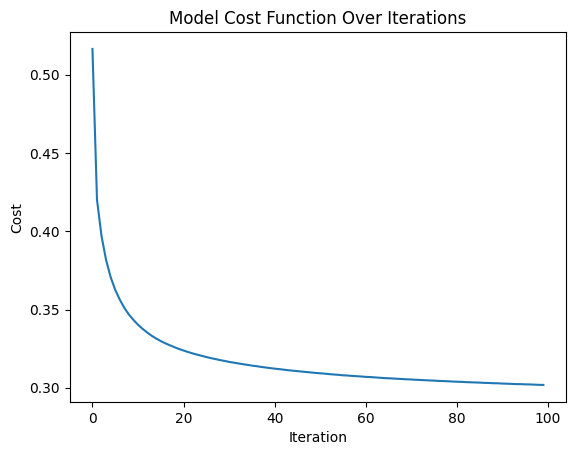

In [53]:
plt.plot(list(map(np.mean, model_5layer_adam.cost_)))

plt.title("Model Cost Function Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Cost")

plt.show()

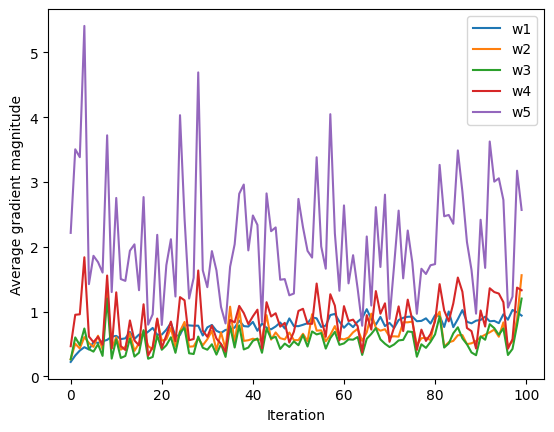

In [54]:
model_5layer_adam.plot_gradients_()

In [55]:
mcnemar_test(y_test, yhat_5layer, yhat_5layer_adam)

False

A model using AdaM on a 5-layer perceptron produces approximately the same accuracy as a 5-layer perceptron without AdaM on this testing set (72.7% vs 73.1%). We fail to reject the null hypothesis for the McNemar test, so we cannot conclude that the predictions of the models are different.